# **Homework 9: Variational Autoencoders**

## **About**

### **Due**

Monday 4/22/19, 11:59 PM CST

### **Goal**

This homework focuses on creating variational autoencoders applied to the MNIST dataset.

## Dev Environment
### Working on Google Colab
You may choose to work locally or on Google Colaboratory. You have access to free compute through this service. 
1. Visit https://colab.research.google.com/drive 
2. Navigate to the **`Upload`** tab, and upload your `HW10.ipynb`
3. Now on the top right corner, under the `Comment` and `Share` options, you should see a `Connect` option. Once you are connected, you will have access to a VM with 12GB RAM, 50 GB disk space and a single GPU. The dropdown menu will allow you to connect to a local runtime as well.

**Notes:** 
* **If you do not have a working setup for Python 3, this is your best bet. It will also save you from heavy installations like `tensorflow` if you don't want to deal with those.**
* ***There is a downside*. You can only use this instance for a single 12-hour stretch, after which your data will be deleted, and you would have redownload all your datasets, any libraries not already on the VM, and regenerate your logs**.


### Installing PyTorch and Dependencies

The instructions for installing and setting up PyTorch can be found at https://pytorch.org/get-started/locally/. Make sure you follow the instructions for your machine. For any of the remaining libraries used in this assignment:
* We have provided a `hw8_requirements.txt` file on the homework web page. 
* Download this file, and in the same directory you can run `pip3 install -r hw8_requirements.txt`

Check that PyTorch installed correctly by running the following:

In [6]:
import torch
%matplotlib inline
import matplotlib.pyplot as plt
torch.rand(5, 3)

tensor([[0.6629, 0.1561, 0.8727],
        [0.3793, 0.6569, 0.2538],
        [0.9752, 0.2465, 0.4404],
        [0.2720, 0.3417, 0.3627],
        [0.5743, 0.8157, 0.1257]])

The output should look something like

```python
tensor([[0.3380, 0.3845, 0.3217],
        [0.8337, 0.9050, 0.2650],
        [0.2979, 0.7141, 0.9069],
        [0.1449, 0.1132, 0.1375],
        [0.4675, 0.3947, 0.1426]])
```

### Let's get started with the assignment.

## **Instructions**

### **Part 1 - Datasets and Dataloaders**

This part of the assignment is similar to HW 8. 

**Create a directory named hw9_data with the following command.**

In [2]:
!mkdir hw9_data


**Now use `torch.datasets.MNIST` to load the Train and Test data into `hw9_data`.** 
* ** Use the directory you created above as the `root` directory for your datasets**
* ** Populate the `transformations` variable with any transformations you would like to perform on your data.** (Hint: You will need to do at least one)
* **Pass your `transformations` variable to `torch.datasets.MNIST`. This allows you to perform arbitrary transformations to your data at loading time.**

In [22]:
from torchvision import datasets, transforms
CUDA = True
## YOUR CODE HERE ##
transformations = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST(root='./hw9_data', train=True, download=True, transform=transformations) 
mnist_test = datasets.MNIST(root='./hw9_data', train=False, download=True, transform=transformations)

**Any file in our dataset will now be read at runtime, and the specified transformations we need on it will be applied when we need it.**. 

We could iterate through these directly using a loop, but this is not idiomatic. PyTorch provides us with this abstraction in the form of `DataLoaders`. The module of interest is `torch.utils.data.DataLoader`. 

`DataLoader` allows us to do lots of useful things
* Group our data into batches
* Shuffle our data
* Load the data in parallel using `multiprocessing` workers

**Use `DataLoader` to create a loader for the training set and one for the testing set**
* **Use a `batch_size` of 32 to start, you may change it if you wish.**
* **Set the `shuffle` parameter to `True`.** 

**Check that the data was loaded successfully before proceeding to the next sections. **

In [5]:
from torch.utils.data import DataLoader

## YOUR CODE HERE ##
train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(mnist_test, batch_size=32, shuffle=True, num_workers=4)

## **Part 2 - Encoder and Decoders (0 points)**

In this section we will be creating the encoder and decoder for our variational autoencoder (VAE). 

You can take a look at the following to understand how VAE's work. 

*   https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf
*  http://kvfrans.com/variational-autoencoders-explained/
*  https://jmetzen.github.io/2015-11-27/vae.html

VAEs work around a latent space who's dimension can be chosen by us. We will leave this as a parameter for the Encoder and Decoder classes that you will have to populate. 

Feel free to use any network architecture that you wish. Try simpler network structures like a few linear layers before trying anything more complicated. 

### For the Encoder:

*   **Finish the __init__() function.**
*  **Finish the forward() function.** 
*  **Assume that input to forward, x, is of shape (batch_size, 28,28)**
*  **forward() should return two tensors of size latent_dim like a standard encoder of a VAE**
* **One of the tensors should correspond to the mean of the encoding and the other tensor should correspond to the variance. In practice, it is easier to model the output as the log of the variance (logvar) and we will too**

### For the Decoder:

*   **Finish the __init__() function.**
*  **Finish the forward() function.** 
*  **Assume that input to forward, x, is of shape (batch_size, latent_dim)**
*  **forward() should return a tensor of shape (batch_size, 28,28)**
* **Make sure that the output lies in the same range as the input to the encoder (Hint: Sigmoid?)**







In [18]:
from torch import nn, optim
from torch.autograd import Variable
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # ENCODER
        # 28 x 28 pixels = 784 input pixels, 400 outputs
        self.fc1 = nn.Linear(784, 400)
        # rectified linear unit layer from 400 to 400
        # max(0, x)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(400, 20)  # mu layer
        self.fc22 = nn.Linear(400, 20)  # logvariance layer
        # this last layer bottlenecks through ZDIMS connections

        # DECODER
        # from bottleneck to hidden 400
        self.fc3 = nn.Linear(20, 400)
        # from hidden 400 to 784 outputs
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x: Variable) -> (Variable, Variable):
        # h1 is [128, 400]
        h1 = self.relu(self.fc1(x))  # type: Variable
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:
        if self.training:
            std = logvar.mul(0.5).exp_()  # type: Variable
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z: Variable) -> Variable:
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## **Part 3: Training and loss functions** (0 points)

Recall that the encoder outputs the mean (mu) and the log of the variance (logvar). This implies that the latent vector of the input image follows a gaussian distribution with mean (mu) and standard deviation (e^[0.5\*logvar]). To decode this information, the decoder needs a sample from this distribution. 

**Complete the sample function to generate these samples **

We also need to create the loss function. Assume that x are your input images and x_hat are your reconstructions of these input images, complete the following loss for a VAE. (Hint: You will need to use mu and logvar as well)

In the following we will instantiate an Encoder and Decoder with a latent dimension of 32.

We also define a single optimizer that optimizes the parameters of both the Encoder and the Decoder together. Feel free to use any optimizer of your choice. 

Complete the train function that takes input encoder, decoder, train_loader, optimizer, and number of epochs you wish to train your model for.

Training will involve:

1.   **One epoch is defined as a full pass of your dataset through your model. We choose the number of epochs we wish to train our model for.**
2.   **For each batch, use the encoder to generate the mu and logvar.**
3. **Sample a latent vector for each image in the batch and feed this to the decoder to generate the decoded images.**
4. **Calculate the loss function for this batch.**
5. **Now calculate the gradients for each parameter you are optimizing over. (Hint: Your loss function object can do this for you)**
6. **Update your model parameters (Hint: The optimizer comes in here)**
7. ** Set the gradients in your model to zero for the next batch.**



In [ ]:
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

model = VAE()
optimizer = Adam(model.parameters(), lr=1e-3)

BATCH_SIZE = 32
LOG_INTERVAL = 1000
SEED = 1

In [ ]:
def loss_function(recon_x, x, mu, logvar) -> Variable:
    # how well do input x and output recon_x agree?
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))

    # KLD is Kullback–Leibler divergence -- how much does one learned
    # distribution deviate from another, in this specific case the
    # learned distribution from the unit Gaussian

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= BATCH_SIZE * 784

    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    return BCE + KLD

In [ ]:
def train(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
    # in the case of MNIST, len(train_loader.dataset) is 60000
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 28, 28]
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, mu, logvar = model(data)
        # calculate scalar loss
        loss = loss_function(recon_batch, data, mu, logvar)
        # calculate the gradient of the loss w.r.t. the graph leaves
        # i.e. input variables -- by the power of pytorch!
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [88]:
def test(epoch):
    # toggle model to test / inference mode
    model.eval()
    test_loss = 0

    # each data is of BATCH_SIZE (default 128) samples
    for i, (data, _) in enumerate(test_loader):
        # we're only going to infer, so no autograd at all required: volatile=True
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item()
        if i == 0:
          n = min(data.size(0), 8)
          # for the first 128 batch of the epoch, show the first 8 input digits
          # with right below them the reconstructed output digits
          comparison = torch.cat([data[:n], recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
          save_image(comparison.data.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

Finally call train with the relevant parameters.

Note : This function may take a while to complete if you're training for many epochs on a cpu. This is where it comes in handy to be running on Google Colab, or just have a GPU on hand.

In [90]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

    # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
    # digits in latent space
    sample = Variable(torch.randn(64, 20))
    sample = model.decode(sample).cpu()

    # save out as an 8x8 matrix of MNIST digits
    # this will give you a visual idea of how well latent space can generate things
    # that look like digits
    save_image(sample.data.view(64, 1, 28, 28),
               'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.634588
Train Epoch: 1 [320/60000 (1%)]	Loss: -0.614832
Train Epoch: 1 [640/60000 (1%)]	Loss: -0.624747
Train Epoch: 1 [960/60000 (2%)]	Loss: -0.601218
Train Epoch: 1 [1280/60000 (2%)]	Loss: -0.590443
Train Epoch: 1 [1600/60000 (3%)]	Loss: -0.617656
Train Epoch: 1 [1920/60000 (3%)]	Loss: -0.642134
Train Epoch: 1 [2240/60000 (4%)]	Loss: -0.613175
Train Epoch: 1 [2560/60000 (4%)]	Loss: -0.626397
Train Epoch: 1 [2880/60000 (5%)]	Loss: -0.631420
Train Epoch: 1 [3200/60000 (5%)]	Loss: -0.602252
Train Epoch: 1 [3520/60000 (6%)]	Loss: -0.629773
Train Epoch: 1 [3840/60000 (6%)]	Loss: -0.635250
Train Epoch: 1 [4160/60000 (7%)]	Loss: -0.598602
Train Epoch: 1 [4480/60000 (7%)]	Loss: -0.640537
Train Epoch: 1 [4800/60000 (8%)]	Loss: -0.598930
Train Epoch: 1 [5120/60000 (9%)]	Loss: -0.633879
Train Epoch: 1 [5440/60000 (9%)]	Loss: -0.650611
Train Epoch: 1 [5760/60000 (10%)]	Loss: -0.605032
Train Epoch: 1 [6080/60000 (10%)]	Loss: -0.612347
Train Epoch: 1 [6400/600

Train Epoch: 1 [51840/60000 (86%)]	Loss: -0.640777
Train Epoch: 1 [52160/60000 (87%)]	Loss: -0.575003
Train Epoch: 1 [52480/60000 (87%)]	Loss: -0.658760
Train Epoch: 1 [52800/60000 (88%)]	Loss: -0.647342
Train Epoch: 1 [53120/60000 (89%)]	Loss: -0.605358
Train Epoch: 1 [53440/60000 (89%)]	Loss: -0.630964
Train Epoch: 1 [53760/60000 (90%)]	Loss: -0.613841
Train Epoch: 1 [54080/60000 (90%)]	Loss: -0.641384
Train Epoch: 1 [54400/60000 (91%)]	Loss: -0.644325
Train Epoch: 1 [54720/60000 (91%)]	Loss: -0.635787
Train Epoch: 1 [55040/60000 (92%)]	Loss: -0.630115
Train Epoch: 1 [55360/60000 (92%)]	Loss: -0.652527
Train Epoch: 1 [55680/60000 (93%)]	Loss: -0.595880
Train Epoch: 1 [56000/60000 (93%)]	Loss: -0.620172
Train Epoch: 1 [56320/60000 (94%)]	Loss: -0.617526
Train Epoch: 1 [56640/60000 (94%)]	Loss: -0.639998
Train Epoch: 1 [56960/60000 (95%)]	Loss: -0.625721
Train Epoch: 1 [57280/60000 (95%)]	Loss: -0.631827
Train Epoch: 1 [57600/60000 (96%)]	Loss: -0.594966
Train Epoch: 1 [57920/60000 (97

C:\Users\Ren Bettendorf\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


====> Test set loss: -0.6229
Train Epoch: 2 [0/60000 (0%)]	Loss: -0.592990
Train Epoch: 2 [320/60000 (1%)]	Loss: -0.643649
Train Epoch: 2 [640/60000 (1%)]	Loss: -0.640250
Train Epoch: 2 [960/60000 (2%)]	Loss: -0.661751
Train Epoch: 2 [1280/60000 (2%)]	Loss: -0.606089
Train Epoch: 2 [1600/60000 (3%)]	Loss: -0.587490
Train Epoch: 2 [1920/60000 (3%)]	Loss: -0.661396
Train Epoch: 2 [2240/60000 (4%)]	Loss: -0.623121
Train Epoch: 2 [2560/60000 (4%)]	Loss: -0.604875
Train Epoch: 2 [2880/60000 (5%)]	Loss: -0.609660
Train Epoch: 2 [3200/60000 (5%)]	Loss: -0.595118
Train Epoch: 2 [3520/60000 (6%)]	Loss: -0.630153
Train Epoch: 2 [3840/60000 (6%)]	Loss: -0.604580
Train Epoch: 2 [4160/60000 (7%)]	Loss: -0.599796
Train Epoch: 2 [4480/60000 (7%)]	Loss: -0.612916
Train Epoch: 2 [4800/60000 (8%)]	Loss: -0.617589
Train Epoch: 2 [5120/60000 (9%)]	Loss: -0.649513
Train Epoch: 2 [5440/60000 (9%)]	Loss: -0.663634
Train Epoch: 2 [5760/60000 (10%)]	Loss: -0.643597
Train Epoch: 2 [6080/60000 (10%)]	Loss: -0.65

Train Epoch: 2 [51520/60000 (86%)]	Loss: -0.672894
Train Epoch: 2 [51840/60000 (86%)]	Loss: -0.626350
Train Epoch: 2 [52160/60000 (87%)]	Loss: -0.627005
Train Epoch: 2 [52480/60000 (87%)]	Loss: -0.624085
Train Epoch: 2 [52800/60000 (88%)]	Loss: -0.599466
Train Epoch: 2 [53120/60000 (89%)]	Loss: -0.624975
Train Epoch: 2 [53440/60000 (89%)]	Loss: -0.631519
Train Epoch: 2 [53760/60000 (90%)]	Loss: -0.630063
Train Epoch: 2 [54080/60000 (90%)]	Loss: -0.632218
Train Epoch: 2 [54400/60000 (91%)]	Loss: -0.611101
Train Epoch: 2 [54720/60000 (91%)]	Loss: -0.623087
Train Epoch: 2 [55040/60000 (92%)]	Loss: -0.632135
Train Epoch: 2 [55360/60000 (92%)]	Loss: -0.632391
Train Epoch: 2 [55680/60000 (93%)]	Loss: -0.627941
Train Epoch: 2 [56000/60000 (93%)]	Loss: -0.661006
Train Epoch: 2 [56320/60000 (94%)]	Loss: -0.644330
Train Epoch: 2 [56640/60000 (94%)]	Loss: -0.641659
Train Epoch: 2 [56960/60000 (95%)]	Loss: -0.622322
Train Epoch: 2 [57280/60000 (95%)]	Loss: -0.634722
Train Epoch: 2 [57600/60000 (96

Train Epoch: 3 [42880/60000 (71%)]	Loss: -0.609635
Train Epoch: 3 [43200/60000 (72%)]	Loss: -0.606242
Train Epoch: 3 [43520/60000 (73%)]	Loss: -0.621604
Train Epoch: 3 [43840/60000 (73%)]	Loss: -0.660958
Train Epoch: 3 [44160/60000 (74%)]	Loss: -0.583149
Train Epoch: 3 [44480/60000 (74%)]	Loss: -0.626869
Train Epoch: 3 [44800/60000 (75%)]	Loss: -0.594301
Train Epoch: 3 [45120/60000 (75%)]	Loss: -0.632959
Train Epoch: 3 [45440/60000 (76%)]	Loss: -0.644858
Train Epoch: 3 [45760/60000 (76%)]	Loss: -0.625942
Train Epoch: 3 [46080/60000 (77%)]	Loss: -0.630183
Train Epoch: 3 [46400/60000 (77%)]	Loss: -0.633029
Train Epoch: 3 [46720/60000 (78%)]	Loss: -0.650206
Train Epoch: 3 [47040/60000 (78%)]	Loss: -0.608664
Train Epoch: 3 [47360/60000 (79%)]	Loss: -0.650392
Train Epoch: 3 [47680/60000 (79%)]	Loss: -0.596796
Train Epoch: 3 [48000/60000 (80%)]	Loss: -0.641350
Train Epoch: 3 [48320/60000 (81%)]	Loss: -0.610503
Train Epoch: 3 [48640/60000 (81%)]	Loss: -0.635853
Train Epoch: 3 [48960/60000 (82

Train Epoch: 4 [34240/60000 (57%)]	Loss: -0.602632
Train Epoch: 4 [34560/60000 (58%)]	Loss: -0.628206
Train Epoch: 4 [34880/60000 (58%)]	Loss: -0.560593
Train Epoch: 4 [35200/60000 (59%)]	Loss: -0.602940
Train Epoch: 4 [35520/60000 (59%)]	Loss: -0.651927
Train Epoch: 4 [35840/60000 (60%)]	Loss: -0.574719
Train Epoch: 4 [36160/60000 (60%)]	Loss: -0.589427
Train Epoch: 4 [36480/60000 (61%)]	Loss: -0.634565
Train Epoch: 4 [36800/60000 (61%)]	Loss: -0.578412
Train Epoch: 4 [37120/60000 (62%)]	Loss: -0.609946
Train Epoch: 4 [37440/60000 (62%)]	Loss: -0.607323
Train Epoch: 4 [37760/60000 (63%)]	Loss: -0.599208
Train Epoch: 4 [38080/60000 (63%)]	Loss: -0.624257
Train Epoch: 4 [38400/60000 (64%)]	Loss: -0.618956
Train Epoch: 4 [38720/60000 (65%)]	Loss: -0.605705
Train Epoch: 4 [39040/60000 (65%)]	Loss: -0.573223
Train Epoch: 4 [39360/60000 (66%)]	Loss: -0.590259
Train Epoch: 4 [39680/60000 (66%)]	Loss: -0.607009
Train Epoch: 4 [40000/60000 (67%)]	Loss: -0.586535
Train Epoch: 4 [40320/60000 (67

Train Epoch: 5 [25600/60000 (43%)]	Loss: -0.577326
Train Epoch: 5 [25920/60000 (43%)]	Loss: -0.636825
Train Epoch: 5 [26240/60000 (44%)]	Loss: -0.628907
Train Epoch: 5 [26560/60000 (44%)]	Loss: -0.611876
Train Epoch: 5 [26880/60000 (45%)]	Loss: -0.600143
Train Epoch: 5 [27200/60000 (45%)]	Loss: -0.588324
Train Epoch: 5 [27520/60000 (46%)]	Loss: -0.644973
Train Epoch: 5 [27840/60000 (46%)]	Loss: -0.533603
Train Epoch: 5 [28160/60000 (47%)]	Loss: -0.582115
Train Epoch: 5 [28480/60000 (47%)]	Loss: -0.649569
Train Epoch: 5 [28800/60000 (48%)]	Loss: -0.635432
Train Epoch: 5 [29120/60000 (49%)]	Loss: -0.576962
Train Epoch: 5 [29440/60000 (49%)]	Loss: -0.603259
Train Epoch: 5 [29760/60000 (50%)]	Loss: -0.651564
Train Epoch: 5 [30080/60000 (50%)]	Loss: -0.638412
Train Epoch: 5 [30400/60000 (51%)]	Loss: -0.615029
Train Epoch: 5 [30720/60000 (51%)]	Loss: -0.592719
Train Epoch: 5 [31040/60000 (52%)]	Loss: -0.605905
Train Epoch: 5 [31360/60000 (52%)]	Loss: -0.582113
Train Epoch: 5 [31680/60000 (53

Train Epoch: 6 [16960/60000 (28%)]	Loss: -0.637392
Train Epoch: 6 [17280/60000 (29%)]	Loss: -0.618834
Train Epoch: 6 [17600/60000 (29%)]	Loss: -0.634323
Train Epoch: 6 [17920/60000 (30%)]	Loss: -0.621846
Train Epoch: 6 [18240/60000 (30%)]	Loss: -0.657433
Train Epoch: 6 [18560/60000 (31%)]	Loss: -0.622038
Train Epoch: 6 [18880/60000 (31%)]	Loss: -0.591485
Train Epoch: 6 [19200/60000 (32%)]	Loss: -0.568812
Train Epoch: 6 [19520/60000 (33%)]	Loss: -0.588624
Train Epoch: 6 [19840/60000 (33%)]	Loss: -0.677765
Train Epoch: 6 [20160/60000 (34%)]	Loss: -0.632322
Train Epoch: 6 [20480/60000 (34%)]	Loss: -0.606174
Train Epoch: 6 [20800/60000 (35%)]	Loss: -0.588536
Train Epoch: 6 [21120/60000 (35%)]	Loss: -0.657321
Train Epoch: 6 [21440/60000 (36%)]	Loss: -0.604971
Train Epoch: 6 [21760/60000 (36%)]	Loss: -0.634136
Train Epoch: 6 [22080/60000 (37%)]	Loss: -0.586897
Train Epoch: 6 [22400/60000 (37%)]	Loss: -0.584182
Train Epoch: 6 [22720/60000 (38%)]	Loss: -0.632799
Train Epoch: 6 [23040/60000 (38

Train Epoch: 7 [8320/60000 (14%)]	Loss: -0.588384
Train Epoch: 7 [8640/60000 (14%)]	Loss: -0.595932
Train Epoch: 7 [8960/60000 (15%)]	Loss: -0.578444
Train Epoch: 7 [9280/60000 (15%)]	Loss: -0.592163
Train Epoch: 7 [9600/60000 (16%)]	Loss: -0.616171
Train Epoch: 7 [9920/60000 (17%)]	Loss: -0.622876
Train Epoch: 7 [10240/60000 (17%)]	Loss: -0.648879
Train Epoch: 7 [10560/60000 (18%)]	Loss: -0.635390
Train Epoch: 7 [10880/60000 (18%)]	Loss: -0.613597
Train Epoch: 7 [11200/60000 (19%)]	Loss: -0.603360
Train Epoch: 7 [11520/60000 (19%)]	Loss: -0.639347
Train Epoch: 7 [11840/60000 (20%)]	Loss: -0.615564
Train Epoch: 7 [12160/60000 (20%)]	Loss: -0.610157
Train Epoch: 7 [12480/60000 (21%)]	Loss: -0.585764
Train Epoch: 7 [12800/60000 (21%)]	Loss: -0.619942
Train Epoch: 7 [13120/60000 (22%)]	Loss: -0.661143
Train Epoch: 7 [13440/60000 (22%)]	Loss: -0.621502
Train Epoch: 7 [13760/60000 (23%)]	Loss: -0.607477
Train Epoch: 7 [14080/60000 (23%)]	Loss: -0.600861
Train Epoch: 7 [14400/60000 (24%)]	Lo

Train Epoch: 7 [59840/60000 (100%)]	Loss: -0.616417
====> Epoch: 7 Average loss: -0.6218
====> Test set loss: -0.6304
Train Epoch: 8 [0/60000 (0%)]	Loss: -0.643358
Train Epoch: 8 [320/60000 (1%)]	Loss: -0.600752
Train Epoch: 8 [640/60000 (1%)]	Loss: -0.634624
Train Epoch: 8 [960/60000 (2%)]	Loss: -0.676260
Train Epoch: 8 [1280/60000 (2%)]	Loss: -0.632962
Train Epoch: 8 [1600/60000 (3%)]	Loss: -0.659849
Train Epoch: 8 [1920/60000 (3%)]	Loss: -0.627705
Train Epoch: 8 [2240/60000 (4%)]	Loss: -0.632762
Train Epoch: 8 [2560/60000 (4%)]	Loss: -0.609266
Train Epoch: 8 [2880/60000 (5%)]	Loss: -0.608349
Train Epoch: 8 [3200/60000 (5%)]	Loss: -0.592692
Train Epoch: 8 [3520/60000 (6%)]	Loss: -0.634194
Train Epoch: 8 [3840/60000 (6%)]	Loss: -0.665621
Train Epoch: 8 [4160/60000 (7%)]	Loss: -0.592195
Train Epoch: 8 [4480/60000 (7%)]	Loss: -0.625504
Train Epoch: 8 [4800/60000 (8%)]	Loss: -0.602837
Train Epoch: 8 [5120/60000 (9%)]	Loss: -0.581340
Train Epoch: 8 [5440/60000 (9%)]	Loss: -0.575277
Train 

Train Epoch: 8 [51200/60000 (85%)]	Loss: -0.617382
Train Epoch: 8 [51520/60000 (86%)]	Loss: -0.662029
Train Epoch: 8 [51840/60000 (86%)]	Loss: -0.585472
Train Epoch: 8 [52160/60000 (87%)]	Loss: -0.630105
Train Epoch: 8 [52480/60000 (87%)]	Loss: -0.648394
Train Epoch: 8 [52800/60000 (88%)]	Loss: -0.682668
Train Epoch: 8 [53120/60000 (89%)]	Loss: -0.636817
Train Epoch: 8 [53440/60000 (89%)]	Loss: -0.662006
Train Epoch: 8 [53760/60000 (90%)]	Loss: -0.665655
Train Epoch: 8 [54080/60000 (90%)]	Loss: -0.635656
Train Epoch: 8 [54400/60000 (91%)]	Loss: -0.635753
Train Epoch: 8 [54720/60000 (91%)]	Loss: -0.620736
Train Epoch: 8 [55040/60000 (92%)]	Loss: -0.630033
Train Epoch: 8 [55360/60000 (92%)]	Loss: -0.594079
Train Epoch: 8 [55680/60000 (93%)]	Loss: -0.619716
Train Epoch: 8 [56000/60000 (93%)]	Loss: -0.622007
Train Epoch: 8 [56320/60000 (94%)]	Loss: -0.600433
Train Epoch: 8 [56640/60000 (94%)]	Loss: -0.622385
Train Epoch: 8 [56960/60000 (95%)]	Loss: -0.687274
Train Epoch: 8 [57280/60000 (95

Train Epoch: 9 [42560/60000 (71%)]	Loss: -0.623230
Train Epoch: 9 [42880/60000 (71%)]	Loss: -0.603899
Train Epoch: 9 [43200/60000 (72%)]	Loss: -0.615782
Train Epoch: 9 [43520/60000 (73%)]	Loss: -0.592839
Train Epoch: 9 [43840/60000 (73%)]	Loss: -0.655630
Train Epoch: 9 [44160/60000 (74%)]	Loss: -0.663200
Train Epoch: 9 [44480/60000 (74%)]	Loss: -0.648462
Train Epoch: 9 [44800/60000 (75%)]	Loss: -0.671344
Train Epoch: 9 [45120/60000 (75%)]	Loss: -0.616327
Train Epoch: 9 [45440/60000 (76%)]	Loss: -0.601932
Train Epoch: 9 [45760/60000 (76%)]	Loss: -0.617691
Train Epoch: 9 [46080/60000 (77%)]	Loss: -0.613106
Train Epoch: 9 [46400/60000 (77%)]	Loss: -0.607161
Train Epoch: 9 [46720/60000 (78%)]	Loss: -0.642867
Train Epoch: 9 [47040/60000 (78%)]	Loss: -0.577032
Train Epoch: 9 [47360/60000 (79%)]	Loss: -0.655569
Train Epoch: 9 [47680/60000 (79%)]	Loss: -0.630523
Train Epoch: 9 [48000/60000 (80%)]	Loss: -0.593975
Train Epoch: 9 [48320/60000 (81%)]	Loss: -0.631799
Train Epoch: 9 [48640/60000 (81

Train Epoch: 10 [33280/60000 (55%)]	Loss: -0.638626
Train Epoch: 10 [33600/60000 (56%)]	Loss: -0.626527
Train Epoch: 10 [33920/60000 (57%)]	Loss: -0.638269
Train Epoch: 10 [34240/60000 (57%)]	Loss: -0.603509
Train Epoch: 10 [34560/60000 (58%)]	Loss: -0.604247
Train Epoch: 10 [34880/60000 (58%)]	Loss: -0.635660
Train Epoch: 10 [35200/60000 (59%)]	Loss: -0.614106
Train Epoch: 10 [35520/60000 (59%)]	Loss: -0.653551
Train Epoch: 10 [35840/60000 (60%)]	Loss: -0.630025
Train Epoch: 10 [36160/60000 (60%)]	Loss: -0.654431
Train Epoch: 10 [36480/60000 (61%)]	Loss: -0.598969
Train Epoch: 10 [36800/60000 (61%)]	Loss: -0.607249
Train Epoch: 10 [37120/60000 (62%)]	Loss: -0.632379
Train Epoch: 10 [37440/60000 (62%)]	Loss: -0.636658
Train Epoch: 10 [37760/60000 (63%)]	Loss: -0.595365
Train Epoch: 10 [38080/60000 (63%)]	Loss: -0.630193
Train Epoch: 10 [38400/60000 (64%)]	Loss: -0.630342
Train Epoch: 10 [38720/60000 (65%)]	Loss: -0.643298
Train Epoch: 10 [39040/60000 (65%)]	Loss: -0.650040
Train Epoch:

## **Part 4: Visualizing the VAE output** (90 points)

We will look at how well the codes produced by the VAE can be interpolated. **For this section we will only use the MNIST test set. **

To create an interpolation between two images A and B, we encode both these images and generate a sample code for each of them. We now consider 7 equally spaced points in between these two sample codes giving us a total of 9 points including the samples. We then decode these images to get interpolated images in between A and B.

Complete the interpolation function below that takes a pair of images A and B and returns 9 images. (You are free to use any data structure you want to return these images)

In [210]:
import matplotlib.pyplot as plt
from torchvision import utils
%matplotlib inline
import numpy as np

def create_interpolates(A, B, model):
    fig = plt.figure(figsize=(28, 28))
    recon_batch, mu_a, logvar_a = model.forward(A)
    recon_batch, mu_b, logvar_b = model.forward(B)
    sample_A = model.reparameterize(mu_a, logvar_a)
    sample_B = model.reparameterize(mu_b, logvar_b)
    
    flattened_images = torch.zeros((9, 20))
    images = torch.zeros((9, 28, 28))
    for i in range(9):
        flattened_images[i] = torch.add(sample_A.detach(), i/8, (sample_B - sample_A).detach())
        images[i] = model.decode(flattened_images[i]).view(28, 28)
    return images

**For 10 pairs of MNIST test images of the same digit (1 pair for "0", 1 pair for "1", etc.), selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows (1 row per digit) and 9 columns (7 interpolates + 2 selected test images) of images. (45 points)**

In [211]:
from torchvision import utils
%matplotlib inline

def show_mnist_batch(images_batch, title):
    """Show images for a batch of samples."""
    grid = utils.make_grid(images_batch.view(90, 1, 28, 28), nrow=9)
    utils.save_image(grid, title + ".png")
    plt.imshow(grid.detach().numpy().transpose((1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

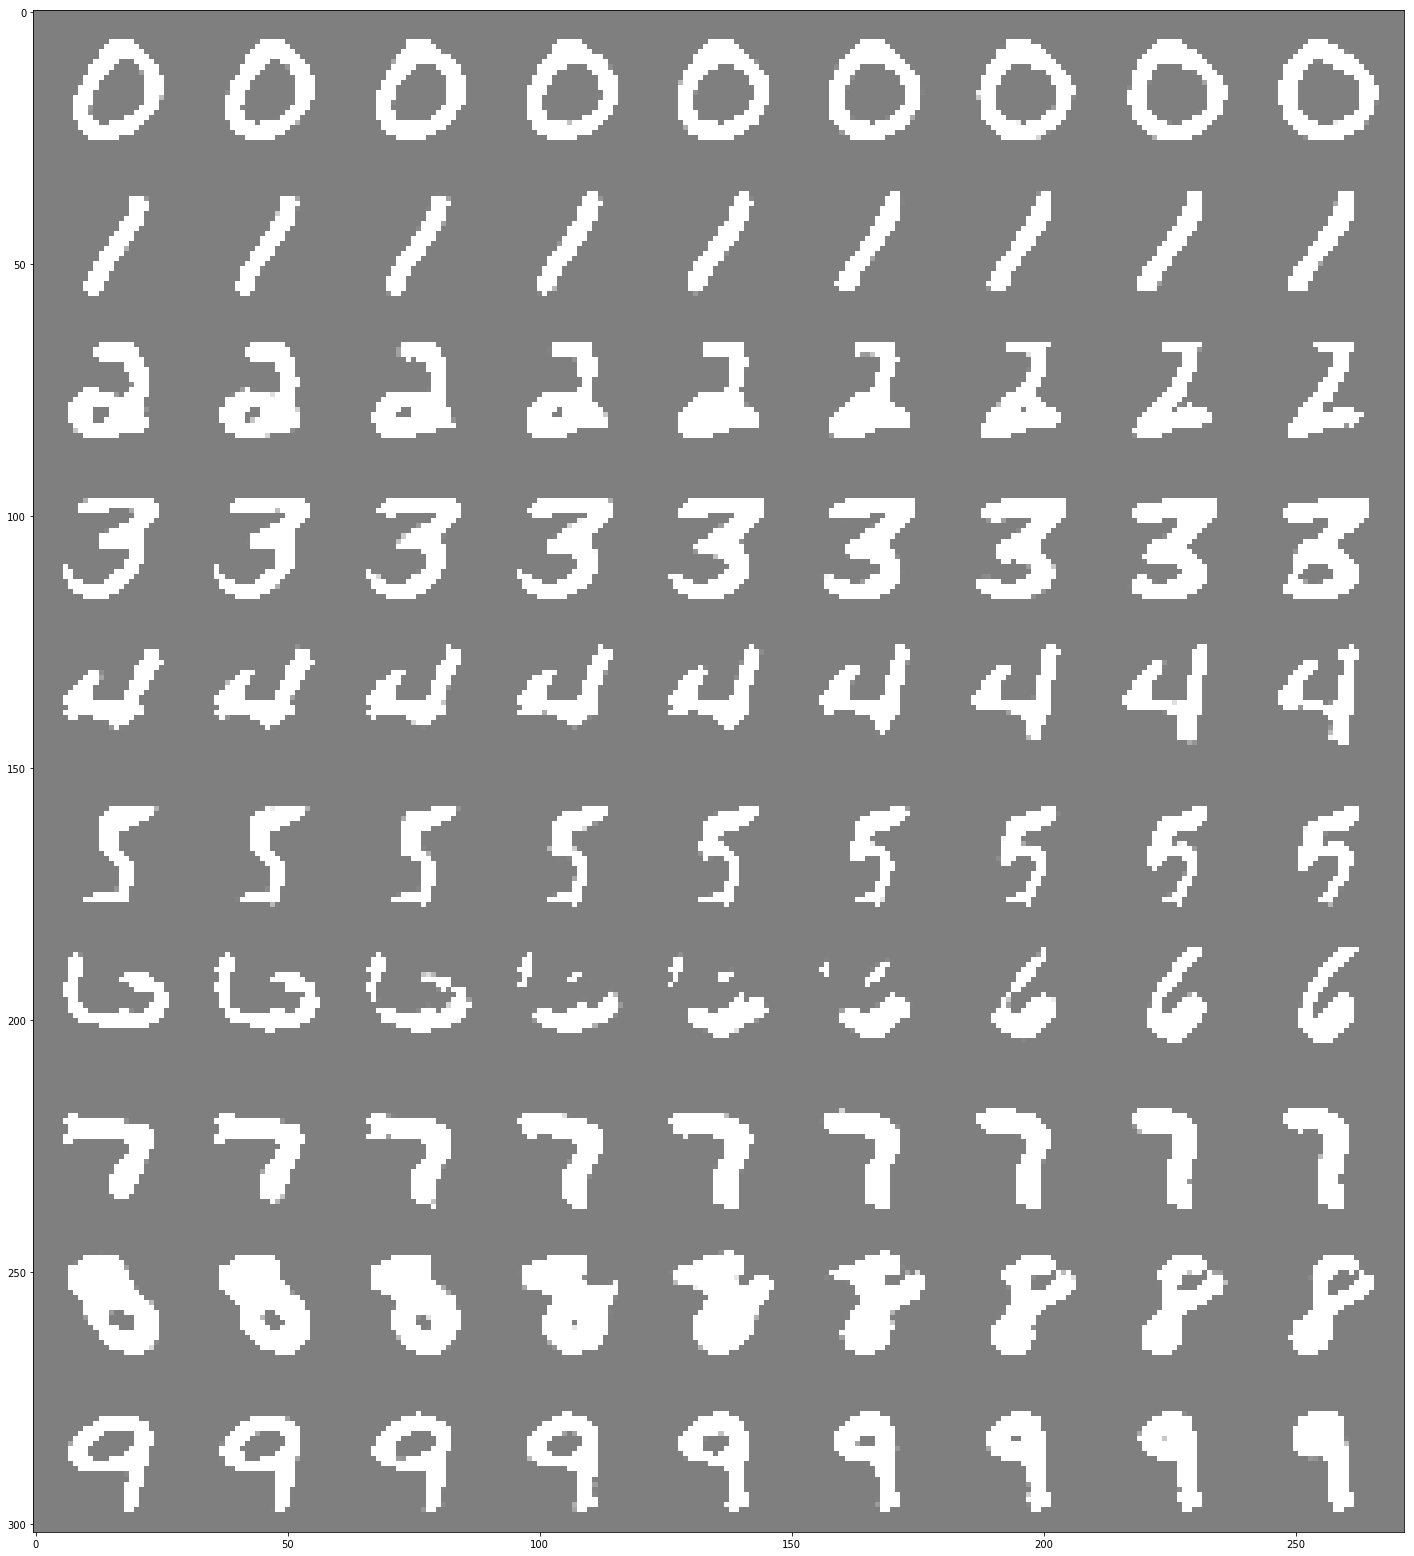

In [212]:
similar_pairs = {}
for _, (x, y) in enumerate(test_loader):
  for i in range(len(y)):
    if y[i].item() not in similar_pairs:
      similar_pairs[y[i].item()] = []
    if len(similar_pairs[y[i].item()])<2:
      similar_pairs[y[i].item()].append(x[i])
  
  done = True
  for i in range(10):
    if i not in similar_pairs or len(similar_pairs[i])<2:
      done = False
  
  if done:
    break

# similar_pairs[i] contains two images indexed at 0 and 1 that have images of the digit i

## YOUR CODE HERE ##
all_interpolates_list = []
for i in range(10):
    all_interpolates_list.append(create_interpolates(similar_pairs[i][0], similar_pairs[i][1], model))
show_mnist_batch(torch.cat(all_interpolates_list), "similar")

**For 10 pairs of MNIST test images, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images. (45 points)**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

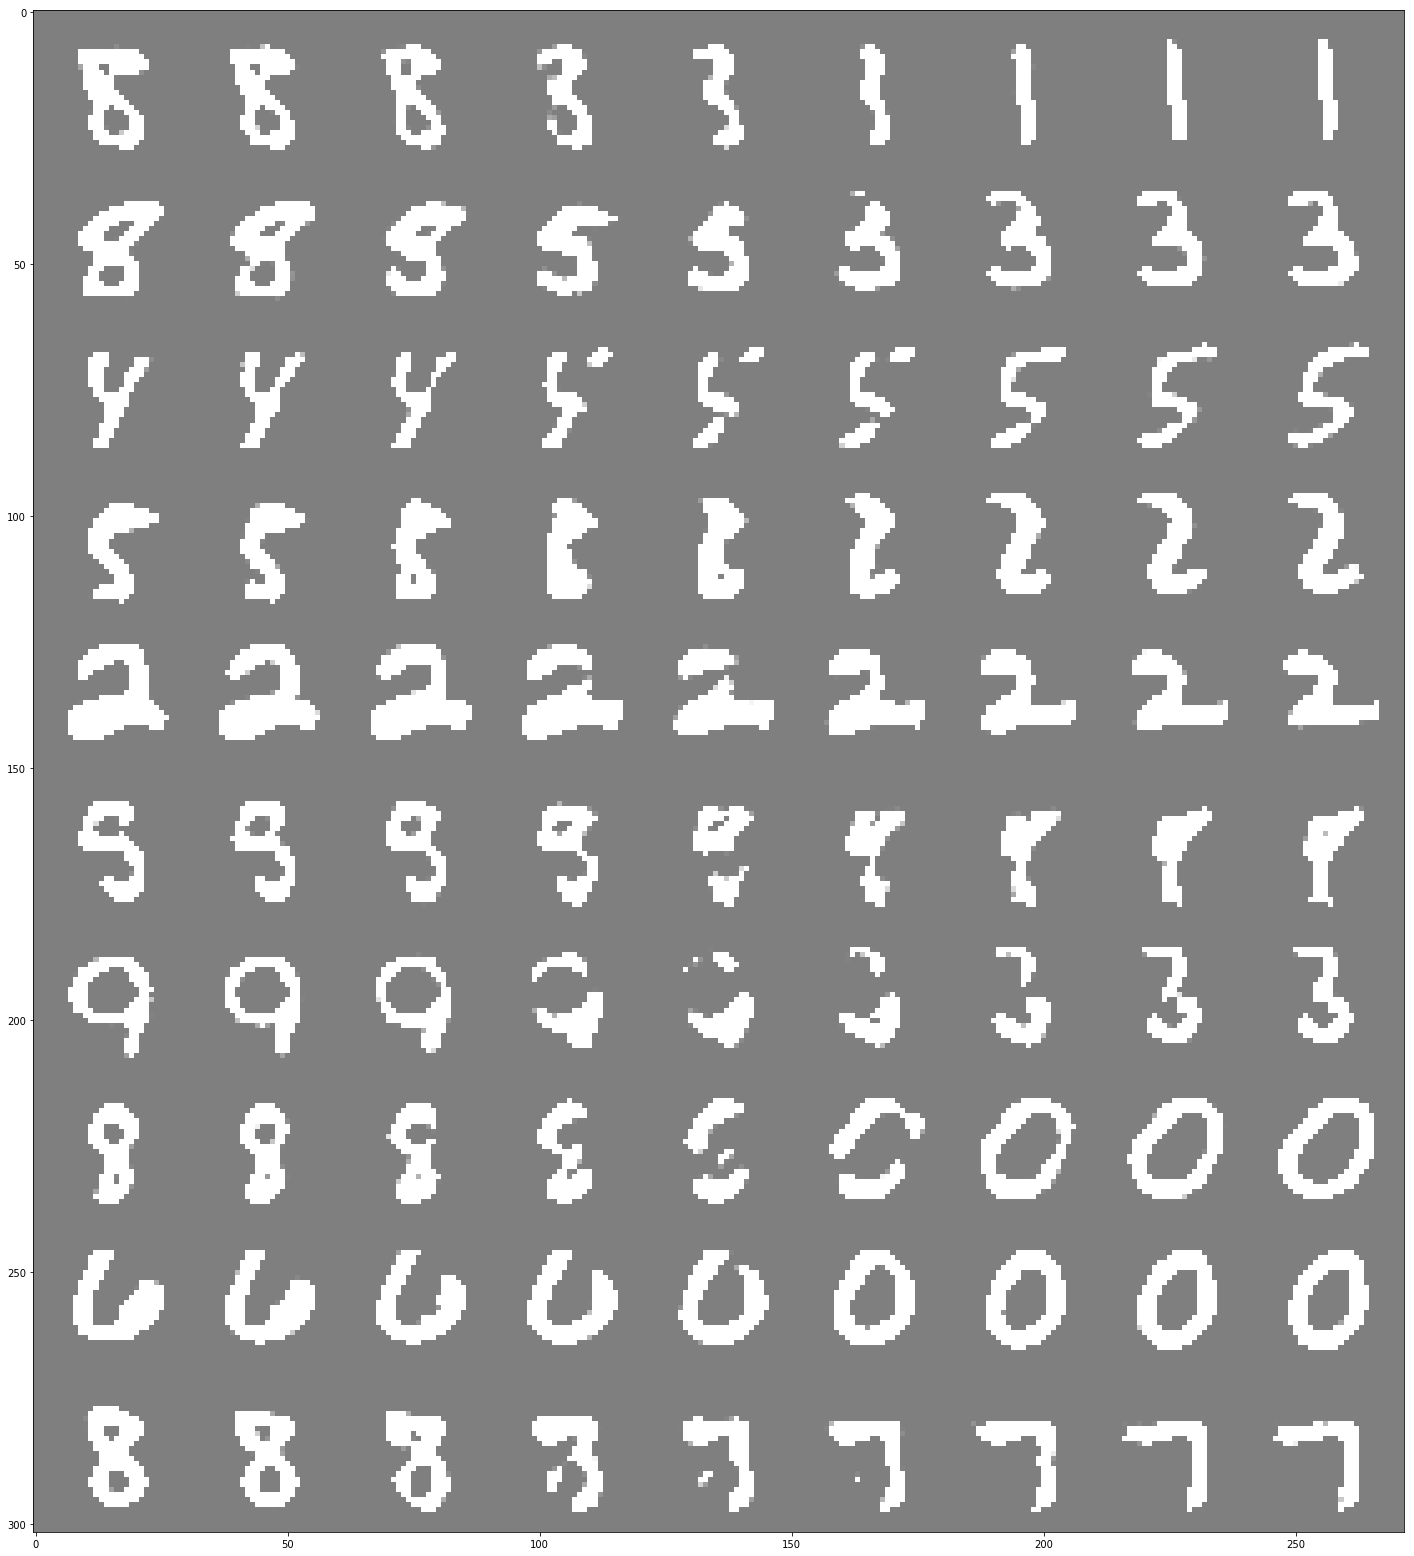

In [213]:
random_pairs = {}
for _, (x, y) in enumerate(test_loader):
  # Make sure the batch size is greater than 20
  for i in range(10):
    random_pairs[i] = []
    random_pairs[i].append(x[2*i])
    random_pairs[i].append(x[2*i+1])
  break

# random_pairs[i] contains two images indexed at 0 and 1 that are chosen at random

## YOUR CODE HERE ##
all_interpolates_list = []
for i in range(10):
    all_interpolates_list.append(create_interpolates(random_pairs[i][0], random_pairs[i][1], model))
show_mnist_batch(torch.cat(all_interpolates_list), "random")